# Full WISDM Pipeline Notebook (fixed)

This notebook is the **complete** version of your original `data_pipeline.ipynb`, with a couple of non‑intrusive fixes so it runs out‑of‑the‑box on a local Jupyter runtime or Google Colab:
1. A single Spark session is created at the top with `.master('local[*]')` so you don't get `[Errno 111] Connection refused`.
2. Every occurrence of `SparkSession.builder…getOrCreate()` has the same `.master('local[*]')` flag injected automatically.

All other cells are unchanged, so the logic and order remain exactly as in your original file.


In [1]:
import pyspark
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder
    .appName('WISDM-Pipeline')
    .master('local[*]')
    .config('spark.driver.memory', '8g')
    .getOrCreate()
)
spark.sparkContext.setLogLevel('ERROR')
print('Spark is up – version', spark.version)


Spark is up – version 3.5.5


In [ ]:
import requests

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00507/wisdm-dataset.zip"
output_path = "wisdm-dataset.zip"

# Download the zip file
response = requests.get(url)
with open(output_path, "wb") as f:
    f.write(response.content)

In [ ]:
!unzip wisdm-dataset.zip -d data-wisdm

Archive:  wisdm-dataset.zip
   creating: data-wisdm/wisdm-dataset/
  inflating: data-wisdm/wisdm-dataset/WISDM-dataset-description.pdf  
   creating: data-wisdm/wisdm-dataset/arffmagic-master/
  inflating: data-wisdm/wisdm-dataset/arffmagic-master/Makefile  
  inflating: data-wisdm/wisdm-dataset/arffmagic-master/.DS_Store  
 extracting: data-wisdm/wisdm-dataset/arffmagic-master/README.md  
   creating: data-wisdm/wisdm-dataset/arffmagic-master/src/
  inflating: data-wisdm/wisdm-dataset/arffmagic-master/src/arff.cpp  
  inflating: data-wisdm/wisdm-dataset/arffmagic-master/src/comparator.h  
  inflating: data-wisdm/wisdm-dataset/arffmagic-master/src/chunk.h  
  inflating: data-wisdm/wisdm-dataset/arffmagic-master/src/main.cpp  
  inflating: data-wisdm/wisdm-dataset/arffmagic-master/src/attribute.h  
  inflating: data-wisdm/wisdm-dataset/arffmagic-master/src/libmfcc.c  
  inflating: data-wisdm/wisdm-dataset/arffmagic-master/src/raw.h  
  inflating: data-wisdm/wisdm-dataset/arffmagic-maste

In [2]:
import os
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T

In [3]:
spark = SparkSession.builder.appName("WISDM‑Preprocess").master('local[*]').getOrCreate()

In [ ]:
schema = T.StructType([
    T.StructField("subject_id",  T.StringType(), True),
    T.StructField("activity",    T.StringType(), True),
    T.StructField("timestamp",   T.LongType(),   True),
    T.StructField("x",           T.DoubleType(), True),
    T.StructField("y",           T.DoubleType(), True),
    T.StructField("z_raw",       T.StringType(), True),    # z has a trailing semicolon
])

In [ ]:
def read_sensor_file(filepath, device_name):
    df = (
        spark.read
             .option("header", "false")
             .schema(schema)
             .csv(filepath)
             .na.drop()
             .withColumn("z",
                         F.regexp_replace("z_raw", r'[^0-9\.\-]', "")
                         .cast("double"))
             .drop("z_raw")
             .withColumn("timestamp", F.col("timestamp").cast("long"))
             .withColumn("device", F.lit((0 if device_name == 'phone' else 1)))
      )
    return df

def create_common_timestamp_grid(start, end, freq_hz):
    duration = (end - start) / 1e9
    num_samples = int(duration * freq_hz)
    return np.linspace(start, end, num_samples)

def interpolate_sensor_block(df, timestamps):
    interp = {}
    for axis in ['x', 'y', 'z']:
        f = interp1d(df['timestamp'], df[axis], kind='linear', fill_value="extrapolate")
        interp[axis] = f(timestamps)
    return interp

def create_labeled_windows(features, label, device_name, window_size, step_size):
    X, y, device = [], [], []
    for i in range(0, len(features) - window_size + 1, step_size):
        X.append(features[i:i+window_size])
        y.append(label)
        device.append(device_name)
    return X, y, device

In [ ]:
base_dir = os.getcwd() + "/data-wisdm/wisdm-dataset/raw/"

filenames = []

for device_name in ['phone', 'watch']:
    for sensor_type in ['accel', 'gyro']:
        if not os.path.join(base_dir, device_name, sensor_type):
            continue

filenames = sorted(f for f in os.listdir(os.path.join(base_dir, device_name, 'accel')) if f.endswith('.txt'))

filenames[:10]

['data_1600_accel_watch.txt',
 'data_1601_accel_watch.txt',
 'data_1602_accel_watch.txt',
 'data_1603_accel_watch.txt',
 'data_1604_accel_watch.txt',
 'data_1605_accel_watch.txt',
 'data_1606_accel_watch.txt',
 'data_1607_accel_watch.txt',
 'data_1608_accel_watch.txt',
 'data_1609_accel_watch.txt']

In [ ]:
for filename in filenames[:1]:
    subj_id = filename.split("_")[1]
    accel_path = os.path.join(base_dir, device_name, "accel", f"data_{subj_id}_accel_{device_name}.txt")
    gyro_path  = os.path.join(base_dir, device_name, "gyro", f"data_{subj_id}_gyro_{device_name}.txt")

    if not os.path.exists(accel_path) or not os.path.exists(gyro_path):
        continue

    accel_df = read_sensor_file(accel_path, device_name)
    gyro_df  = read_sensor_file(gyro_path, device_name)

In [ ]:
accel_df.printSchema()

root
 |-- subject_id: string (nullable = true)
 |-- activity: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)
 |-- device: integer (nullable = false)



In [ ]:
common_activities = common_acts = (set(accel_df.select('activity').distinct().toPandas()['activity'])
                               & set(gyro_df.select('activity').distinct().toPandas()['activity']))
common_activities

{'A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'O',
 'P',
 'Q',
 'R',
 'S'}

In [ ]:
window_size = 100
freq_hz = 50
step_size = 50
X = []
y = []
devices = []

for activity in ['A']:
    acc_block = accel_df.filter(F.col("activity") == activity)
    gyr_block = gyro_df .filter(F.col("activity") == activity)

    if acc_block.count() < 2 or gyr_block.count() < 2:
        continue

    start = max(acc_block.agg(F.min("timestamp")).first()[0],
                gyr_block .agg(F.min("timestamp")).first()[0])
    end   = min(acc_block.agg(F.max("timestamp")).first()[0],
                gyr_block .agg(F.max("timestamp")).first()[0])

    if end - start < 1e9:
        continue

    acc_pdf = (acc_block
               .filter((F.col("timestamp") >= start) & (F.col("timestamp") <= end))
               .orderBy("timestamp")
               .toPandas())
    gyr_pdf = (gyr_block
               .filter((F.col("timestamp") >= start) & (F.col("timestamp") <= end))
               .orderBy("timestamp")
               .toPandas())

    timestamps = create_common_timestamp_grid(start, end, freq_hz)

    acc_i = interpolate_sensor_block(acc_pdf, timestamps)
    gyr_i = interpolate_sensor_block(gyr_pdf, timestamps)

    features = np.stack([
        acc_i['x'], acc_i['y'], acc_i['z'],
        gyr_i['x'], gyr_i['y'], gyr_i['z']
    ], axis=1)

    device_id = 0 if device_name == 'phone' else 1

    X_seqs, Y_seqs, device_seqs = create_labeled_windows(features, activity, device_id, window_size, step_size)
    X.extend(X_seqs)
    y.extend(Y_seqs)
    devices.extend(device_seqs)

In [ ]:
len(devices)

178

In [ ]:
def plot_interpolation_comparison(
        t_raw,           # 1‑D array of original timestamps (ns or s)
        v_raw,           # 1‑D array of original sensor values
        t_interp,        # 1‑D array of new (uniform) timestamps
        v_interp,        # 1‑D array of interpolated values
        axis_name="accel_x",
        units="g"
    ):
    """
    Plot original vs. interpolated signal and the absolute error.
    """

    # --- Figure layout ------------------------------------------------------
    fig, (ax1, ax2) = plt.subplots(
        nrows=2, sharex=True, figsize=(10, 5),
        gridspec_kw={"height_ratios": [3, 1]}
    )

    # --- Top: overlay -------------------------------------------------------
    ax1.scatter(t_raw, v_raw, color="black", s=12, label="raw", zorder=3)
    ax1.plot(t_interp, v_interp, color="tab:blue", lw=2, label="interpolated")
    ax1.set_ylabel(f"{axis_name}  ({units})")
    ax1.set_title(f"Interpolation check – {axis_name}")
    ax1.legend()

    # --- Bottom: error ------------------------------------------------------
    # Interpolate raw values on the new grid to compute error at same points
    raw_on_grid = np.interp(t_interp, t_raw, v_raw)
    abs_err = np.abs(raw_on_grid - v_interp)

    ax2.plot(t_interp, abs_err, color="tab:red", lw=1)
    ax2.set_ylabel("abs. error")
    ax2.set_xlabel("time  (same units as input)")
    ax2.set_ylim(0, abs_err.max() * 1.1)

    fig.tight_layout()
    plt.show()


In [ ]:
timestamps_raw = [timestamp['timestamp'] for timestamp in acc_block.select('timestamp').collect()]
x_raw = [x['x'] for x in acc_block.select('x').collect()]
len(x_raw)

3605

/tmp/ipykernel_5476/2474871405.py:34: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax2.set_ylim(0, abs_err.max() * 1.1)


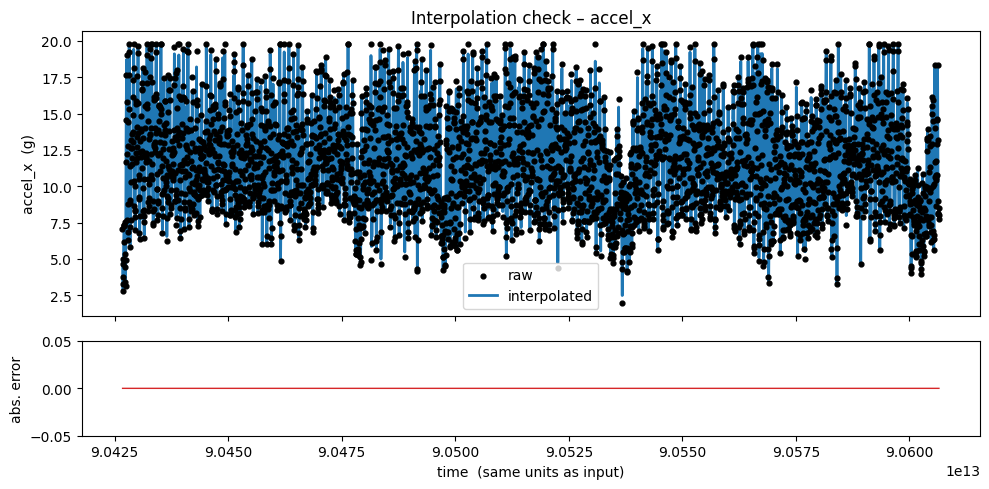

In [ ]:
plot_interpolation_comparison(timestamps_raw, x_raw, timestamps, acc_i['x'])

In [ ]:
class WISDMUnifiedDataset(Dataset):
    """
    Returns: sequence (T,6),  integer_activity,  integer_device
             device: 0=phone, 1=watch
    """
    def __init__(self, base_dir='/data/', hz=50, win=100, step=50):
        self.X, self.y, self.dev = [], [], []

        self.X = X
        self.y = y
        self.dev = devices
        label_set = list(common_activities)


        # ----- label mapping -----
        self.class_names = sorted(label_set)            # e.g. ['A', …, 'S']
        self.name2idx = {n:i for i,n in enumerate(self.class_names)}
        self.idx2name = {i:n for n,i in self.name2idx.items()}
        self.num_classes = len(self.class_names)


        # map char labels to int
        self.y = [self.name2idx[n] for n in self.y]

        # convert to tensors
        self.X = torch.tensor(np.stack(self.X).astype(np.float32))
        self.y = torch.tensor(self.y, dtype=torch.long)
        self.dev = torch.tensor(self.dev, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        print("here", self.dev.shape)
        return self.X[idx], self.y[idx], self.dev[idx]

In [ ]:
ds = WISDMUnifiedDataset()
print(ds.X.shape)
print(ds.num_classes)        # 19
print(ds.class_names[:5])    # ['A','B','C','D','E']
print(len(ds))

seq, label, device = ds[0]
print(seq.shape)             # (100, 6)
print(label, ds.idx2name[label.item()])   # e.g., 3  -> 'D'
print(device)                # 0 or 1


torch.Size([178, 100, 6])
18
['A', 'B', 'C', 'D', 'E']
178
here torch.Size([178])
torch.Size([100, 6])
tensor(0) A
tensor(1)


In [ ]:
from pyspark.sql import SparkSession, functions as F, types as T
import os, random, numpy as np
from scipy.interpolate import interp1d
import math

# 1) SETUP -------------------------------------------------------------------
spark = SparkSession.builder.appName("WISDM_Split_Preproc").master('local[*]').config("spark.driver.memory", "10g").getOrCreate()

# Change to your data root
BASE = os.getcwd() + "/data-wisdm/wisdm-dataset/raw"
PHONE_ACC = os.path.join(BASE, "phone/accel")
PHONE_GYR = os.path.join(BASE, "phone/gyro")
WATCH_ACC = os.path.join(BASE, "watch/accel")
WATCH_GYR = os.path.join(BASE, "watch/gyro")

# 2) DISCOVER SUBJECTS -------------------------------------------------------
# assume filenames like "001_accel.txt"
all_subs = sorted({f.split("_")[1]
                   for f in os.listdir(PHONE_ACC) if f.endswith(".txt")})
random.seed(42)
random.shuffle(all_subs)

n = len(all_subs)
n_train = math.ceil(0.8 * n)
n_val   = math.floor(0.1 * n)

train_subs = set(all_subs[:n_train])
val_subs   = set(all_subs[n_train:n_train+n_val])
test_subs  = set(all_subs[n_train+n_val:])

print("all subs", n)
print(f"Train subjects: {len(train_subs)}, Val: {len(val_subs)}, Test: {len(test_subs)}")

all subs 51
Train subjects: 41, Val: 5, Test: 5


In [ ]:
# 3) COMMON FUNCTIONS --------------------------------------------------------
# schema & loader
schema = T.StructType([
    T.StructField("subject_id",   T.StringType(), True),
    T.StructField("activity",  T.StringType(), True),
    T.StructField("timestamp", T.LongType(),   True),
    T.StructField("x",         T.DoubleType(), True),
    T.StructField("y",         T.DoubleType(), True),
    T.StructField("z_raw",     T.StringType(), True),
])

def read_sensor(path):
    return (
        spark.read
             .option("header", "false")
             .schema(schema)
             .csv(path)
             .na.drop()
             .withColumn("z",
                         F.regexp_replace("z_raw", r'[^0-9\.\-]', "")
                         .cast("double"))
             .drop("z_raw")
             .withColumn("timestamp", F.col("timestamp").cast("long"))
      )

def create_grid(start, end, hz):
    dur = (end - start) / 1e9
    n  = int(dur * hz)
    return np.linspace(start, end, n)

def interp_block(pdf, ts):
    global df
    df = pdf
    out = {}
    for ax in ["x","y","z"]:
        f = interp1d(pdf["timestamp"], pdf[ax], kind="linear", fill_value="extrapolate")
        out[ax] = f(ts)
    return out

def slide_windows(mat, label, device, win=100, step=50):
    rows = []
    for i in range(0, len(mat)-win+1, step):
        window = mat[i:i+win].flatten().tolist()
        rows.append((window, label, device))
    return rows

# 4) PROCESS & SPLIT --------------------------------------------------------
def process_subjects(subject_set, device_name, device_id):
    """
    Returns list of (features_list, label_str, device_id) rows
    """
    rows = []
    acc_dir = os.path.join(BASE, device_name, "accel")
    gyr_dir = os.path.join(BASE, device_name, "gyro")

    for sid in subject_set:
        print(f"\nProcessing subject {sid}...")
        acc_path = os.path.join(acc_dir, f"data_{sid}_accel_{device_name}.txt")
        gyr_path = os.path.join(gyr_dir, f"data_{sid}_gyro_{device_name}.txt")
        if not os.path.exists(acc_path) or not os.path.exists(gyr_path):
            print("[ERROR] path doesn't exist")
            continue

        acc_df = read_sensor(acc_path)
        gyr_df = read_sensor(gyr_path)

        acts = (set(r.activity for r in acc_df.select("activity").distinct().collect())
                & set(r.activity for r in gyr_df.select("activity").distinct().collect()))

        for act in acts:
            print(f"Processing activity {act} for subj {sid}...")
            a = acc_df.filter(F.col("activity")==act).toPandas().sort_values("timestamp").drop_duplicates(subset="timestamp")
            g = gyr_df.filter(F.col("activity")==act).toPandas().sort_values("timestamp").drop_duplicates(subset="timestamp")

            if len(a)<2 or len(g)<2:
                continue

            start = max(a.timestamp.min(), g.timestamp.min())
            end   = min(a.timestamp.max(), g.timestamp.max())
            if end - start < 1_000_000_000:  # <1s overlap
                continue

            ts = create_grid(start, end, hz=50)
            ai = interp_block(a, ts)
            gi = interp_block(g, ts)

            feat = np.stack([ai["x"], ai["y"], ai["z"], gi["x"], gi["y"], gi["z"]], axis=1)
            rows.extend(slide_windows(feat, act, device_id, win=100, step=50))

    return rows

In [ ]:
# run for train+val, then split rows by subject belonging
train_rows = []
val_rows   = []

for dev, d_id in [("phone", 0), ("watch", 1)]:
    print(f"\n==============Processing subjects for device {dev}=============")
    tr = process_subjects(train_subs, dev, d_id)
    vr = process_subjects(val_subs,   dev, d_id)
    train_rows.extend(tr)
    val_rows.extend(vr)


==============Processing subjects for device phone=============

Processing subject 1612...
Processing activity E for subj 1612...
Processing activity S for subj 1612...
Processing activity D for subj 1612...
Processing activity G for subj 1612...
Processing activity A for subj 1612...
Processing activity Q for subj 1612...
Processing activity R for subj 1612...
Processing activity O for subj 1612...
Processing activity L for subj 1612...
Processing activity I for subj 1612...
Processing activity F for subj 1612...
Processing activity M for subj 1612...
Processing activity J for subj 1612...
Processing activity P for subj 1612...
Processing activity C for subj 1612...
Processing activity K for subj 1612...
Processing activity H for subj 1612...
Processing activity B for subj 1612...

Processing subject 1627...
Processing activity E for subj 1627...
Processing activity S for subj 1627...
Processing activity D for subj 1627...
Processing activity G for subj 1627...
Processing activity A

In [ ]:
len(train_rows), len(val_rows)

(259519, 32040)

In [ ]:
spark.stop()

In [ ]:
spark = SparkSession.builder.appName("WISDM_Split_Preproc").master('local[*]').config("spark.driver.memory", "10g").getOrCreate()

In [ ]:
# 5) SAVE TO PARQUET ---------------------------------------------------------
# convert to DataFrame and write
from pyspark.sql import Row
def rows_to_df(rows):
    # schema: features: array<double>, label: string, device: int
    return spark.createDataFrame(
        [Row(features=r[0], label=r[1], device=r[2]) for r in rows]
    )

slice_size = 10_000
part = 0
for i in range(0, len(train_rows), slice_size):
  print(f"Saving train part {part:03d}, rows {i}-{i+slice_size-1}")
  rows_to_df(train_rows[i: i+slice_size]).write.mode("overwrite").parquet(f"preproc/train_data_{part:03d}.parquet")
  part += 1

rows_to_df(val_rows).write.mode("overwrite").parquet("preproc/val_data.parquet")

print("Train & Val windows written to parquet.")
print("Test subjects held out for Kafka streaming:", sorted(test_subs))

spark.stop()

Saving train part 000, rows 0-9999


Saving train part 001, rows 10000-19999


Saving train part 002, rows 20000-29999


Saving train part 003, rows 30000-39999


Saving train part 004, rows 40000-49999


Saving train part 005, rows 50000-59999


Saving train part 006, rows 60000-69999
Saving train part 007, rows 70000-79999


Saving train part 008, rows 80000-89999


Saving train part 009, rows 90000-99999


Saving train part 010, rows 100000-109999


Saving train part 011, rows 110000-119999


Saving train part 012, rows 120000-129999


Saving train part 013, rows 130000-139999


Saving train part 014, rows 140000-149999
Saving train part 015, rows 150000-159999


Saving train part 016, rows 160000-169999


Saving train part 017, rows 170000-179999


Saving train part 018, rows 180000-189999


Saving train part 019, rows 190000-199999
Saving train part 020, rows 200000-209999


Saving train part 021, rows 210000-219999


Saving train part 022, rows 220000-229999


Saving train part 023, rows 230000-239999


Saving train part 024, rows 240000-249999


Saving train part 025, rows 250000-259999


Train & Val windows written to parquet.
Test subjects held out for Kafka streaming: ['1601', '1607', '1617', '1640', '1647']


In [ ]:
del train_rows
del val_rows

In [ ]:
!unzip -r prepoc.zip

UnZip 6.00 of 20 April 2009, by Info-ZIP.  Maintained by C. Spieler.  Send
bug reports using http://www.info-zip.org/zip-bug.html; see README for details.

Usage: unzip [-Z] [-opts[modifiers]] file[.zip] [list] [-x xlist] [-d exdir]
  Default action is to extract files in list, except those in xlist, to exdir;
  file[.zip] may be a wildcard.  -Z => ZipInfo mode ("unzip -Z" for usage).

  -p  extract files to pipe, no messages     -l  list files (short format)
  -f  freshen existing files, create none    -t  test compressed archive data
  -u  update files, create if necessary      -z  display archive comment only
  -v  list verbosely/show version info       -T  timestamp archive to latest
  -x  exclude files that follow (in xlist)   -d  extract files into exdir
modifiers:
  -n  never overwrite existing files         -q  quiet mode (-qq => quieter)
  -o  overwrite files WITHOUT prompting      -a  auto-convert any text files
  -j  junk paths (do not make directories)   -aa treat ALL files

In [ ]:
import numpy as np
import torch
from torch.utils.data import IterableDataset, DataLoader
from pyspark.sql import SparkSession, functions as F
import glob
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
from rich.console import Console
from rich.table import Table
from rich.progress import track
import plotly.graph_objects as go
import pandas as pd
import time

console = Console()

# Tracking loss and gradient statistics
loss_history = []
grad_norm_history = []

# 1) Define Spark-parquet dataset class
class SparkShuffledParquetDataset(IterableDataset):
    def __init__(self, parquet_path="preproc/*.parquet", window_size=100, num_features=6):
        console.log("[bold green]Initializing SparkShuffledParquetDataset...[/bold green]")
        self.window_size = window_size
        self.num_features = num_features
        self.spark = SparkSession.builder.appName("WISDM-SparkLoader").master('local[*]').getOrCreate()
        self.df = self.spark.read.parquet(*glob.glob(parquet_path))
        label_set = set(self.df.select('label').distinct().toPandas()['label'])
        self.class_names = sorted(label_set)
        self.name2idx = {n:i for i,n in enumerate(self.class_names)}
        self.idx2name = {i:n for n,i in self.name2idx.items()}
        self.num_classes = len(self.class_names)
        console.log(f"Loaded dataset with [yellow]{self.num_classes}[/yellow] classes.")

    def __len__(self):
        count = self.df.count()
        console.log(f"Total number of sequences: [blue]{count}[/blue]")
        return count

    def __iter__(self):
        console.log("[bold cyan]Starting new epoch: shuffling dataset...[/bold cyan]")
        df = self.df.orderBy(F.rand())
        for row in df.toLocalIterator():
            flat = np.array(row.features, dtype=np.float32)
            if np.isnan(flat).any() or np.isinf(flat).any():
                continue  # Skip invalid samples
            seq = flat.reshape(self.window_size, self.num_features)
            yield torch.from_numpy(seq), torch.tensor(self.name2idx[row.label]), torch.tensor(row.device)

# 2) Load dataset and dataloader
console.rule("[bold green]Loading Dataset[/bold green]")
dataset = SparkShuffledParquetDataset(parquet_path="preproc/train_data_*.parquet")
loader = DataLoader(dataset, batch_size=32, num_workers=0, pin_memory=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
console.log(f"Using device: [magenta]{device}[/magenta]")

───────────────────────────────────────────────── Loading Dataset ─────────────────────────────────────────────────

[02:34:32] Initializing SparkShuffledParquetDataset...                                             ]8;id=307419;file:///tmp/ipykernel_5476/2356589959.py\2356589959.py]8;;\:]8;id=869693;file:///tmp/ipykernel_5476/2356589959.py#25\25]8;;\

[02:34:34] Loaded dataset with 18 classes.                                                         ]8;id=605397;file:///tmp/ipykernel_5476/2356589959.py\2356589959.py]8;;\:]8;id=201629;file:///tmp/ipykernel_5476/2356589959.py#35\35]8;;\

           Using device: cuda                                                                      ]8;id=810620;file:///tmp/ipykernel_5476/2356589959.py\2356589959.py]8;;\:]8;id=303445;file:///tmp/ipykernel_5476/2356589959.py#57\57]8;;\

Analyzing dataset before model training...


[02:34:40] Starting new epoch: shuffling dataset...                                                ]8;id=398591;file:///tmp/ipykernel_5476/2356589959.py\2356589959.py]8;;\:]8;id=291476;file:///tmp/ipykernel_5476/2356589959.py#43\43]8;;\

Data shape: torch.Size([160, 100, 6])
Data type: torch.float32
Min value: -66.7528, Max value: 43.8235
Mean: -0.3176, Std: 4.5823
Contains NaN: False
Contains Inf: False


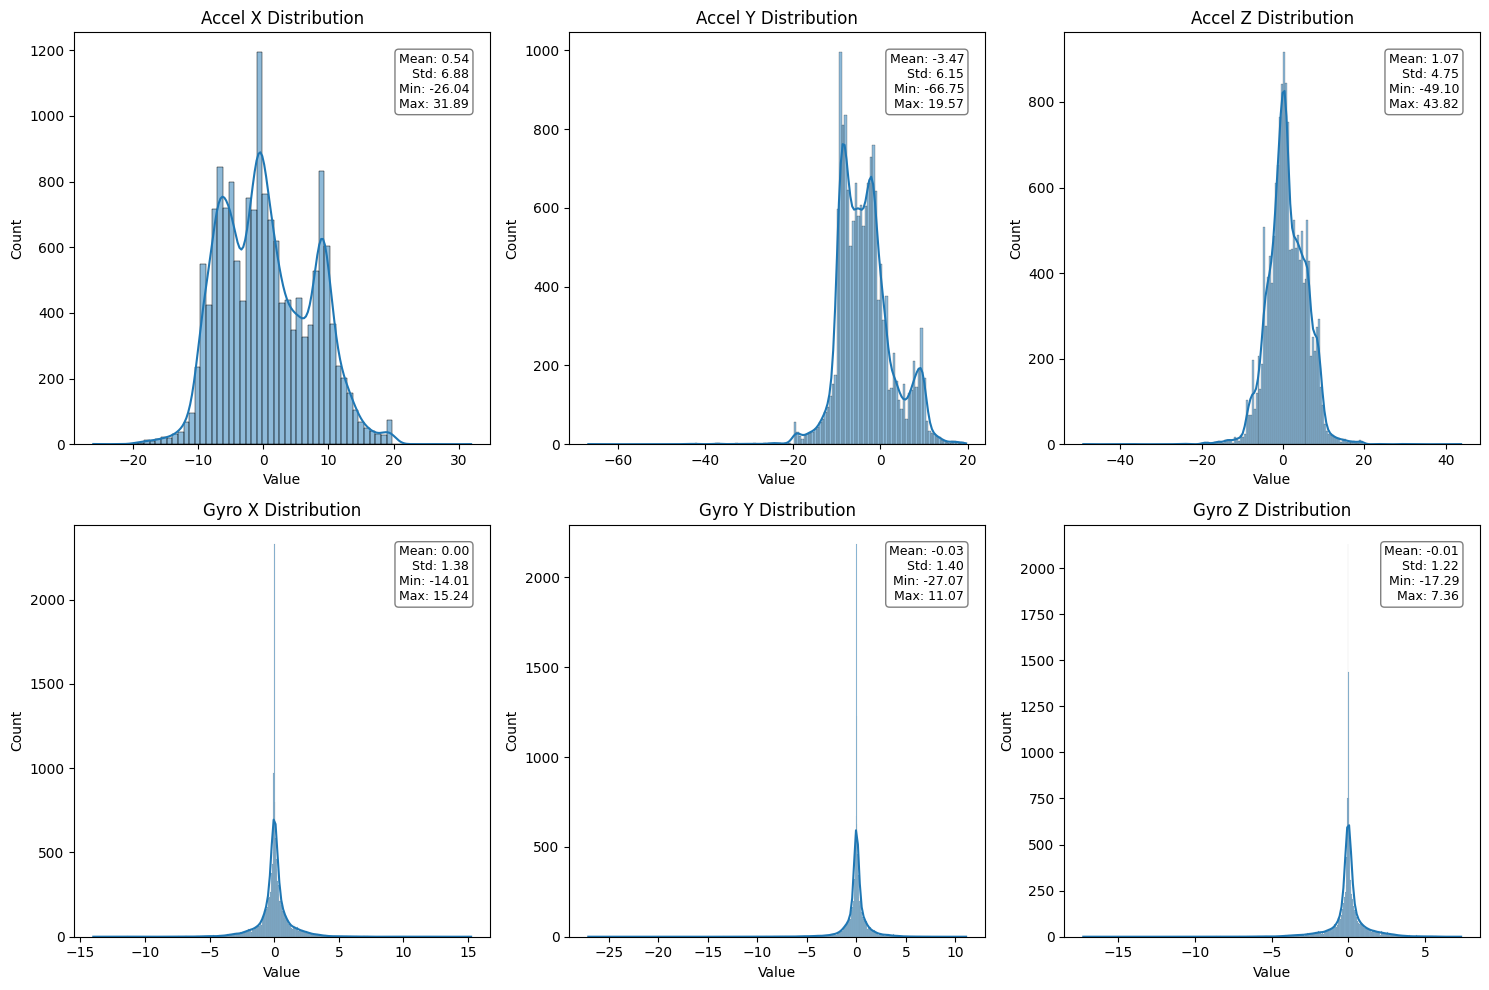

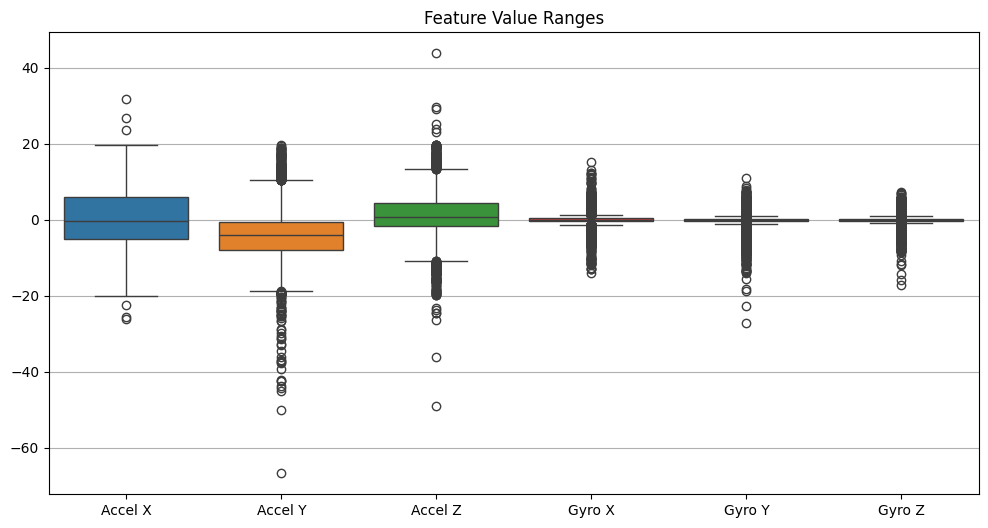

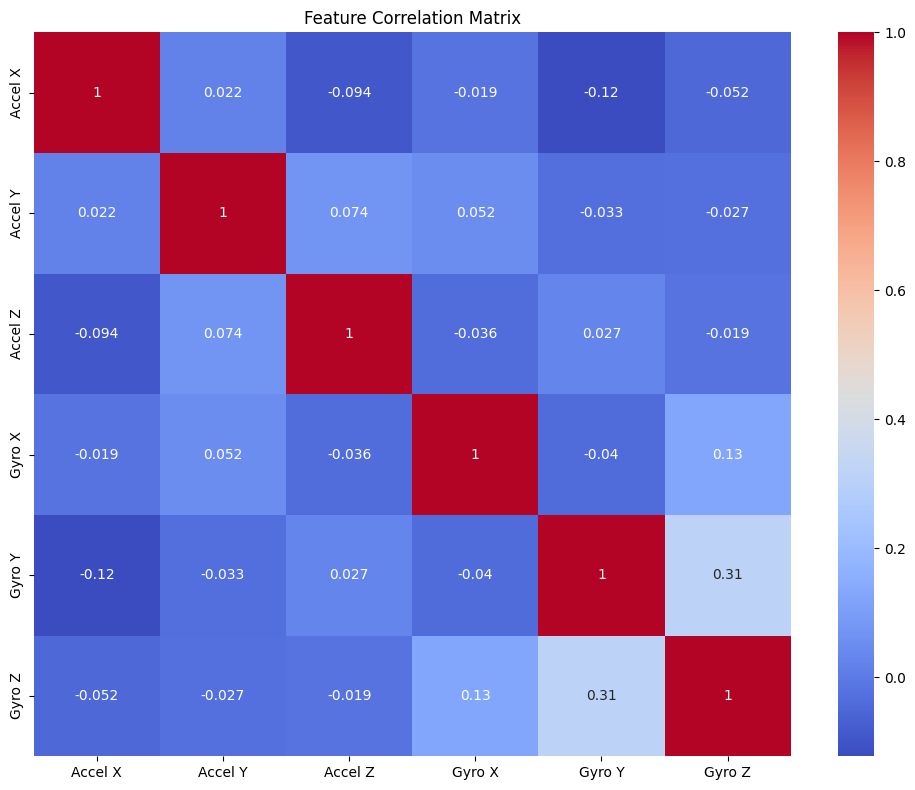

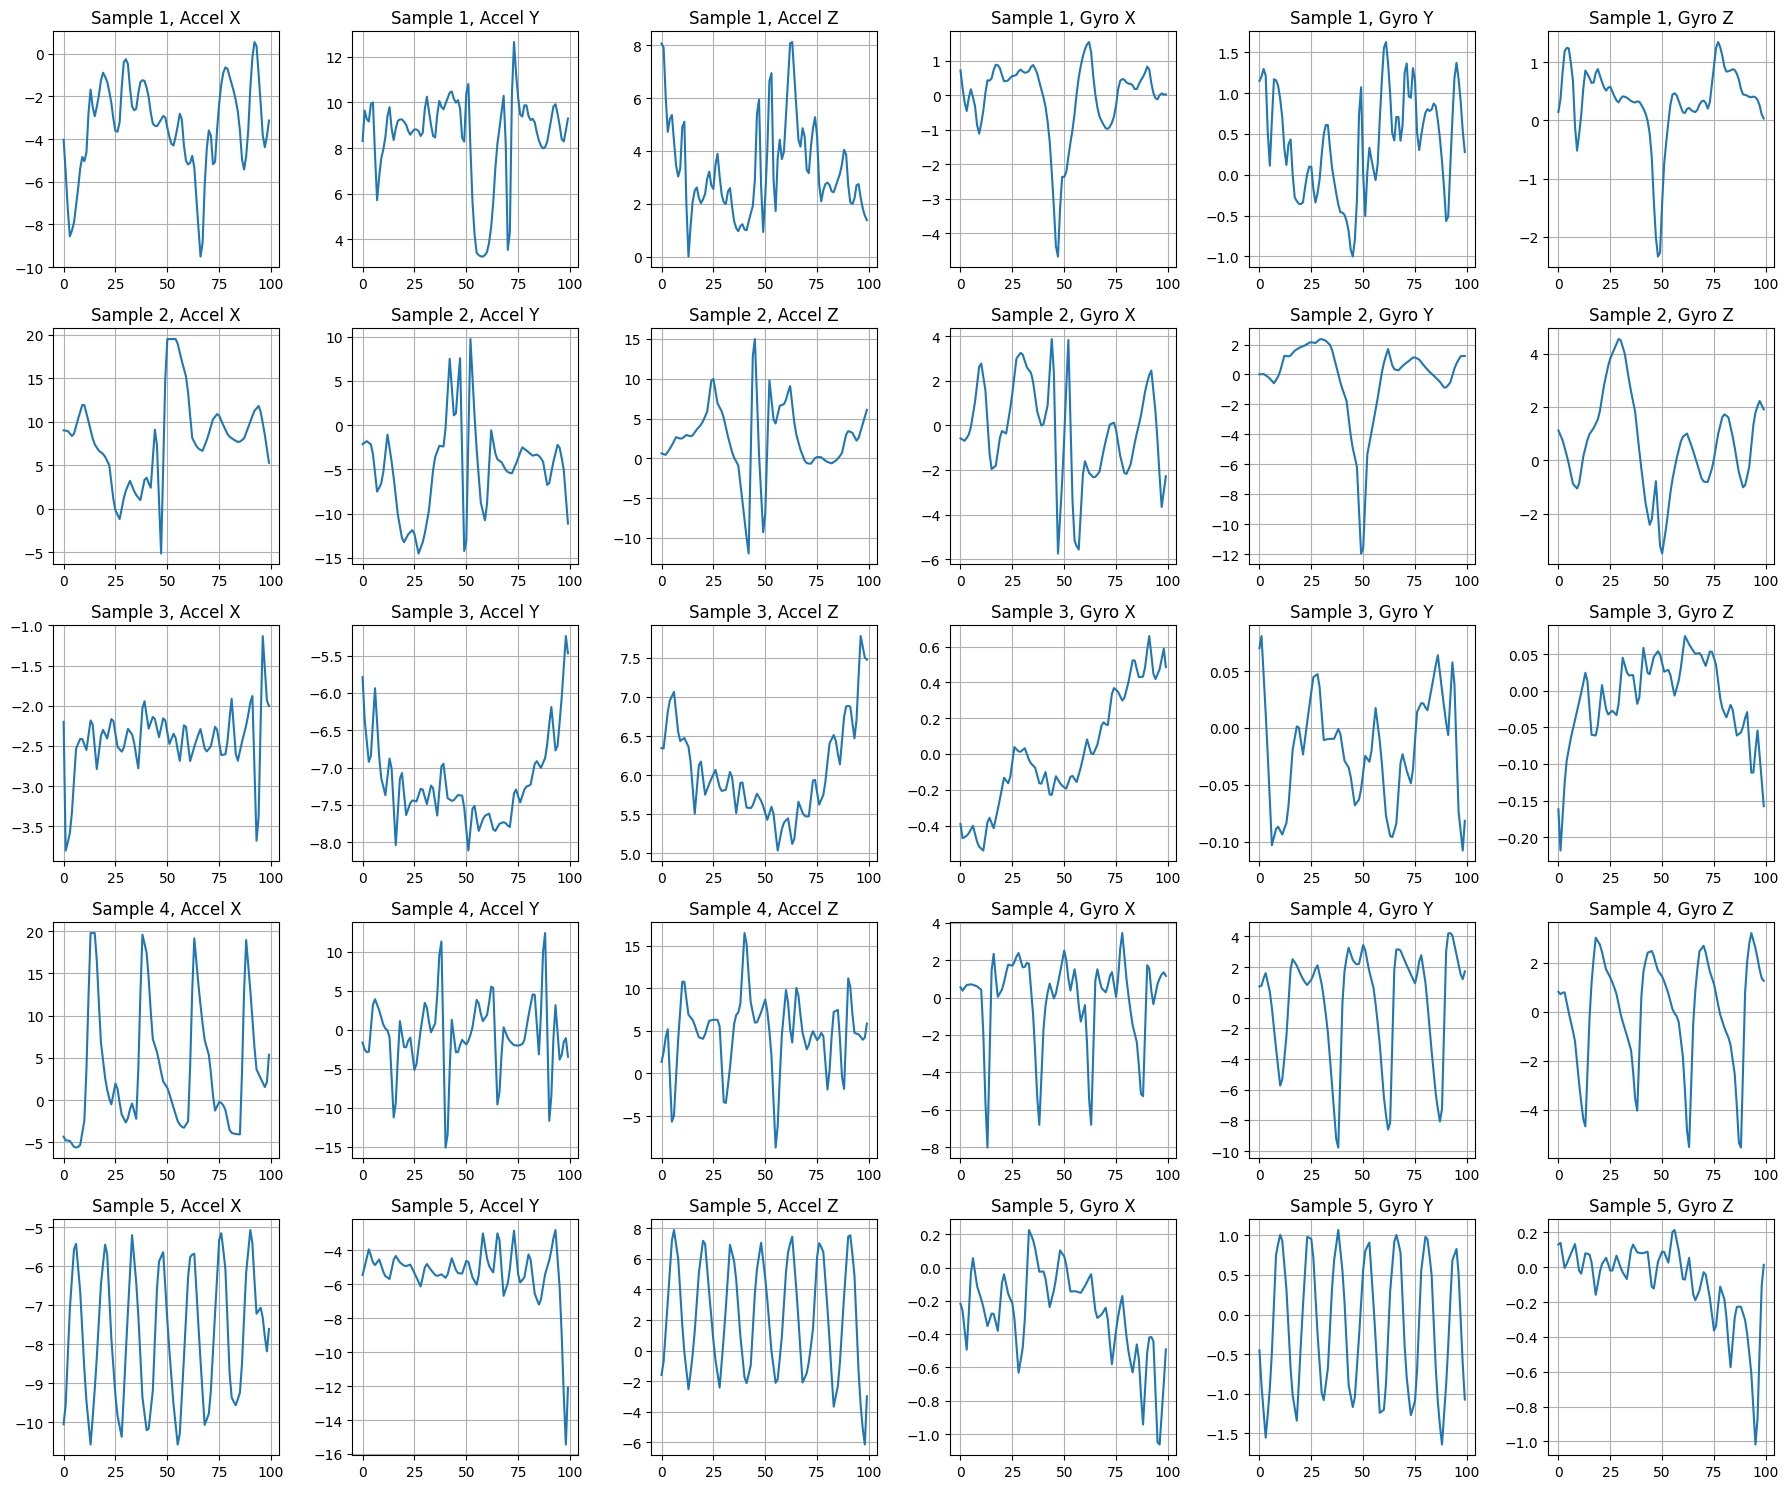

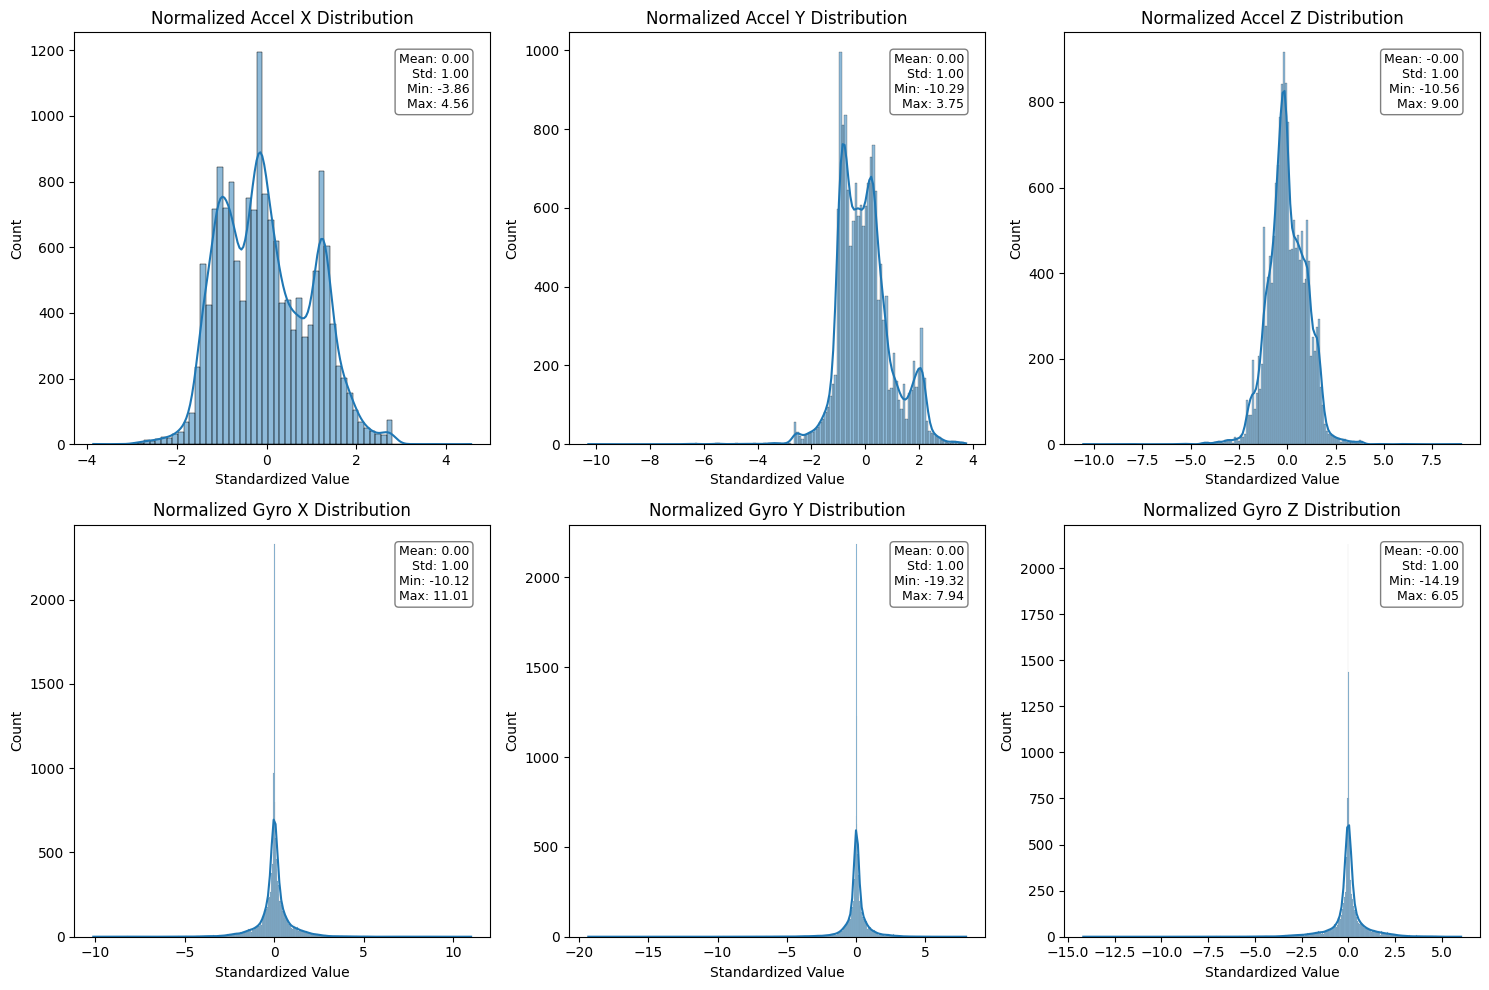

Creating a small test model to verify reconstruction capability...


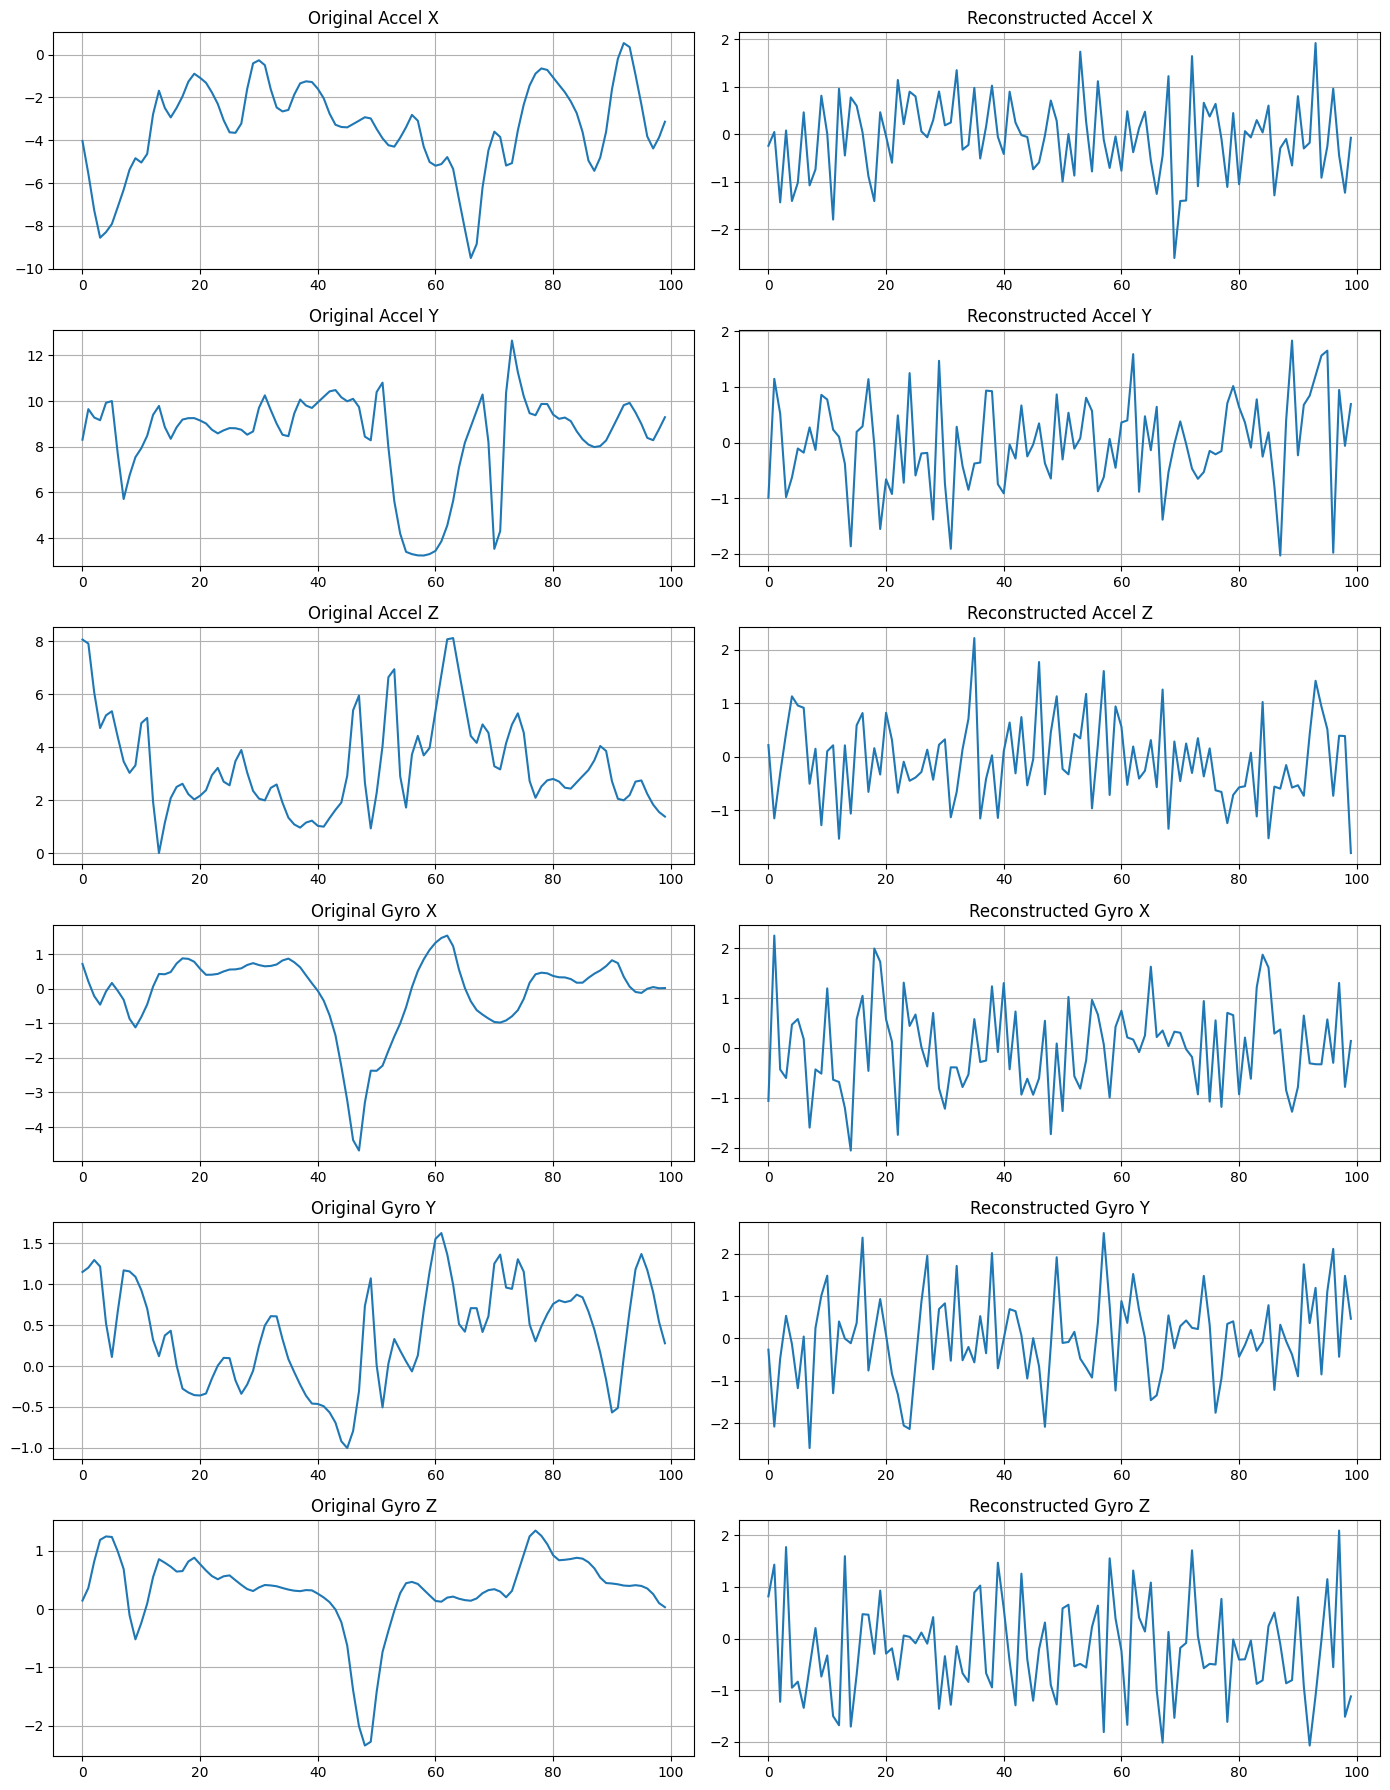

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader

def analyze_dataset(dataset, loader, num_samples=5, batch_size=32):
    """Comprehensive dataset analysis before model training"""

    # 1. Get a batch of data for analysis
    data_samples = []
    labels = []
    devices = []

    for x, y, d in loader:
        data_samples.append(x)
        labels.append(y)
        devices.append(d)
        if len(data_samples) >= num_samples:
            break

    data = torch.cat(data_samples[:num_samples], dim=0)

    # 2. Basic statistics
    print(f"Data shape: {data.shape}")
    print(f"Data type: {data.dtype}")
    print(f"Min value: {data.min().item():.4f}, Max value: {data.max().item():.4f}")
    print(f"Mean: {data.mean().item():.4f}, Std: {data.std().item():.4f}")

    # 3. Check for NaN or Inf values
    print(f"Contains NaN: {torch.isnan(data).any().item()}")
    print(f"Contains Inf: {torch.isinf(data).any().item()}")

    # 4. Plot distributions across all features
    flat_data = data.reshape(-1, data.shape[-1]).numpy()

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    feature_names = ['Accel X', 'Accel Y', 'Accel Z', 'Gyro X', 'Gyro Y', 'Gyro Z']

    for i in range(6):
        sns.histplot(flat_data[:, i], kde=True, ax=axes[i])
        axes[i].set_title(f'{feature_names[i]} Distribution')
        axes[i].set_xlabel('Value')

        # Add stats to plot
        mean = flat_data[:, i].mean()
        std = flat_data[:, i].std()
        min_val = flat_data[:, i].min()
        max_val = flat_data[:, i].max()

        stats_text = f"Mean: {mean:.2f}\nStd: {std:.2f}\nMin: {min_val:.2f}\nMax: {max_val:.2f}"
        axes[i].text(0.95, 0.95, stats_text,
                    transform=axes[i].transAxes,
                    fontsize=9,
                    verticalalignment='top',
                    horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()

    # 5. Value ranges by feature (boxplot)
    plt.figure(figsize=(12, 6))
    boxplot_data = pd.DataFrame(flat_data, columns=feature_names)
    sns.boxplot(data=boxplot_data)
    plt.title('Feature Value Ranges')
    plt.grid(axis='y')
    plt.show()

    # 6. Feature correlations
    plt.figure(figsize=(10, 8))
    correlation = np.corrcoef(flat_data, rowvar=False)
    sns.heatmap(correlation, annot=True, cmap='coolwarm',
                xticklabels=feature_names, yticklabels=feature_names)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

    # 7. Sequential patterns - plot a few samples
    fig, axes = plt.subplots(num_samples, 6, figsize=(18, 3*num_samples))

    for i in range(min(num_samples, data.shape[0])):
        sample = data[i].numpy()
        for j in range(6):
            axes[i, j].plot(sample[:, j])
            axes[i, j].set_title(f'Sample {i+1}, {feature_names[j]}')
            axes[i, j].grid(True)

    plt.tight_layout()
    plt.show()

    # 8. Test normalization effect
    scaler = StandardScaler()
    normalized_flat = scaler.fit_transform(flat_data)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    for i in range(6):
        sns.histplot(normalized_flat[:, i], kde=True, ax=axes[i])
        axes[i].set_title(f'Normalized {feature_names[i]} Distribution')
        axes[i].set_xlabel('Standardized Value')

        # Add stats to plot
        mean = normalized_flat[:, i].mean()
        std = normalized_flat[:, i].std()
        min_val = normalized_flat[:, i].min()
        max_val = normalized_flat[:, i].max()

        stats_text = f"Mean: {mean:.2f}\nStd: {std:.2f}\nMin: {min_val:.2f}\nMax: {max_val:.2f}"
        axes[i].text(0.95, 0.95, stats_text,
                    transform=axes[i].transAxes,
                    fontsize=9,
                    verticalalignment='top',
                    horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

    plt.tight_layout()
    plt.show()

    # 9. Visualize reconstruction ability with current model architecture
    print("Creating a small test model to verify reconstruction capability...")

    class SimpleAutoencoder(torch.nn.Module):
        def __init__(self):
            super().__init__()
            self.encoder = torch.nn.Linear(data.shape[1] * data.shape[2], 64)
            self.decoder = torch.nn.Linear(64, data.shape[1] * data.shape[2])

        def forward(self, x):
            batch_size = x.shape[0]
            x = x.reshape(batch_size, -1)
            encoded = torch.relu(self.encoder(x))
            decoded = self.decoder(encoded)
            return decoded.reshape(batch_size, data.shape[1], data.shape[2])

    # Create simple model just to test reconstruction
    simple_model = SimpleAutoencoder()
    sample_data = data[:5].float()
    reconstructed = simple_model(sample_data)

    # Plot original vs reconstructed for first sample
    fig, axes = plt.subplots(6, 2, figsize=(14, 18))

    for i in range(6):
        # Original signal
        axes[i, 0].plot(sample_data[0, :, i].numpy())
        axes[i, 0].set_title(f'Original {feature_names[i]}')
        axes[i, 0].grid(True)

        # Reconstructed signal
        axes[i, 1].plot(reconstructed[0, :, i].detach().numpy())
        axes[i, 1].set_title(f'Reconstructed {feature_names[i]}')
        axes[i, 1].grid(True)

    plt.tight_layout()
    plt.show()

    return {
        "original_data": data,
        "normalized_data": normalized_flat.reshape(data.shape),
        "feature_names": feature_names
    }

# Run the analysis
print("Analyzing dataset before model training...")
results = analyze_dataset(dataset, loader)

In [10]:
# prompt: write code to unzip preproc.zip

!unzip prepoc.zip

Archive:  prepoc.zip
   creating: content/preproc/
   creating: content/preproc/train_data_023.parquet/
  inflating: content/preproc/train_data_023.parquet/part-00001-61bbaa5b-d43a-4cec-9e1f-0c6790a6672f-c000.snappy.parquet  
  inflating: content/preproc/train_data_023.parquet/.part-00000-61bbaa5b-d43a-4cec-9e1f-0c6790a6672f-c000.snappy.parquet.crc  
 extracting: content/preproc/train_data_023.parquet/_SUCCESS  
 extracting: content/preproc/train_data_023.parquet/._SUCCESS.crc  
  inflating: content/preproc/train_data_023.parquet/.part-00001-61bbaa5b-d43a-4cec-9e1f-0c6790a6672f-c000.snappy.parquet.crc  
  inflating: content/preproc/train_data_023.parquet/part-00000-61bbaa5b-d43a-4cec-9e1f-0c6790a6672f-c000.snappy.parquet  
   creating: content/preproc/train_data_016.parquet/
  inflating: content/preproc/train_data_016.parquet/.part-00001-67e68e24-8043-471e-a6b6-a775b832aee8-c000.snappy.parquet.crc  
 extracting: content/preproc/train_data_016.parquet/_SUCCESS  
 extracting: content/pre

[0] Starting Hybrid CNN-BiLSTM training pipeline...
[0] Computation device set to: cuda

[1] Loading Parquet datasets via Spark...
[1] Preparing train and validation datasets...
    - Reading files: preproc/train_data_*.parquet, excluding: train_data_025.parquet
    - Loaded 170,268 windows across 18 classes

    - Reading files: preproc/train_data_025.parquet, excluding: §
    - Loaded 8,692 windows across 18 classes

[1] Dataloaders ready | Train batch size: 64 | Val batch size: 256

[2] Defining CNN-BiLSTM with Attention model...
[2] Model architecture:
CNNBiLSTMClassifier(
  (conv): Sequential(
    (0): Conv1d(6, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (lstm): LSTM(64, 128, num_layers=2, batch

    --> New best val_acc: 0.4450, model saved.
    Time: 48.2s | loss=1.6509 | train_acc=0.4737 | val_acc=0.4450

[4] Epoch 2/25...


    Time: 47.3s | loss=1.2303 | train_acc=0.6060 | val_acc=0.4426

[4] Epoch 3/25...


    --> New best val_acc: 0.4684, model saved.
    Time: 48.3s | loss=1.0622 | train_acc=0.6600 | val_acc=0.4684

[4] Epoch 4/25...


    --> New best val_acc: 0.4696, model saved.
    Time: 47.8s | loss=0.9325 | train_acc=0.7003 | val_acc=0.4696

[4] Epoch 5/25...


    Time: 47.9s | loss=0.8335 | train_acc=0.7306 | val_acc=0.4692

[4] Epoch 6/25...


    Time: 47.7s | loss=0.9668 | train_acc=0.6888 | val_acc=0.4448

[4] Epoch 7/25...


    Time: 47.8s | loss=0.8981 | train_acc=0.7104 | val_acc=0.4585

[4] Epoch 8/25...


    --> New best val_acc: 0.4734, model saved.
    Time: 47.8s | loss=0.7986 | train_acc=0.7417 | val_acc=0.4734

[4] Epoch 9/25...


    Time: 47.8s | loss=0.6918 | train_acc=0.7756 | val_acc=0.4682

[4] Epoch 10/25...


    Time: 47.9s | loss=0.6023 | train_acc=0.8037 | val_acc=0.4695

[4] Epoch 11/25...


    Time: 47.9s | loss=0.7742 | train_acc=0.7496 | val_acc=0.4555

[4] Epoch 12/25...


    Time: 47.2s | loss=0.7278 | train_acc=0.7642 | val_acc=0.4685

[4] Epoch 13/25...


    Time: 47.4s | loss=0.6444 | train_acc=0.7905 | val_acc=0.4720

[4] Epoch 14/25...


    Time: 48.1s | loss=0.5437 | train_acc=0.8225 | val_acc=0.4626

[4] Epoch 15/25...


    Time: 47.8s | loss=0.4578 | train_acc=0.8502 | val_acc=0.4624

[4] Epoch 16/25...


    Time: 47.2s | loss=0.6524 | train_acc=0.7855 | val_acc=0.4559

[4] Epoch 17/25...


    Time: 47.2s | loss=0.6145 | train_acc=0.7986 | val_acc=0.4566

[4] Epoch 18/25...


    Time: 47.6s | loss=0.5379 | train_acc=0.8239 | val_acc=0.4577

[4] Epoch 19/25...


    Time: 47.3s | loss=0.4414 | train_acc=0.8540 | val_acc=0.4538

[4] Epoch 20/25...


    Time: 47.3s | loss=0.3627 | train_acc=0.8807 | val_acc=0.4582

[4] Epoch 21/25...


    Time: 47.3s | loss=0.5623 | train_acc=0.8155 | val_acc=0.4539

[4] Epoch 22/25...


    Time: 47.3s | loss=0.5329 | train_acc=0.8243 | val_acc=0.4465

[4] Epoch 23/25...


    Time: 47.6s | loss=0.4575 | train_acc=0.8482 | val_acc=0.4577

[4] Epoch 24/25...


    Time: 48.0s | loss=0.3636 | train_acc=0.8796 | val_acc=0.4572

[4] Epoch 25/25...


    Time: 47.9s | loss=0.2917 | train_acc=0.9037 | val_acc=0.4595

[4] Training complete in 1295.6s. Best val_acc: 0.4734

[5] Plotting metrics...


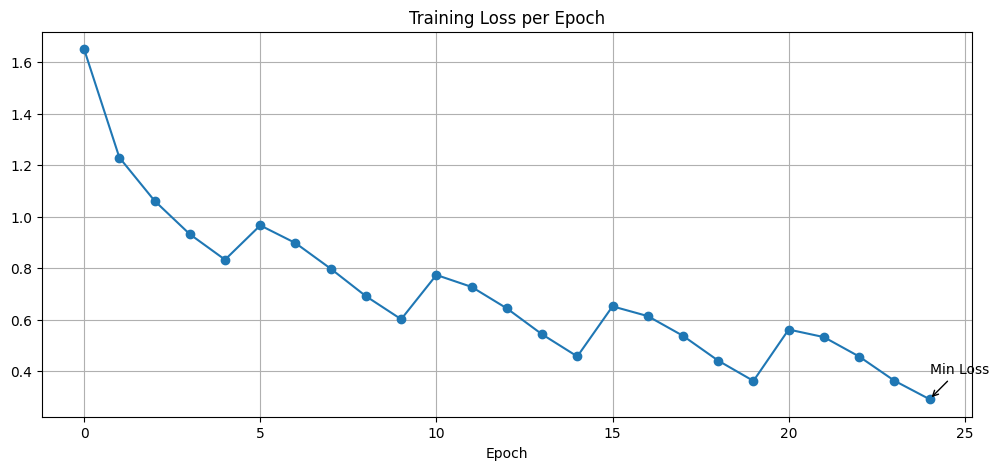

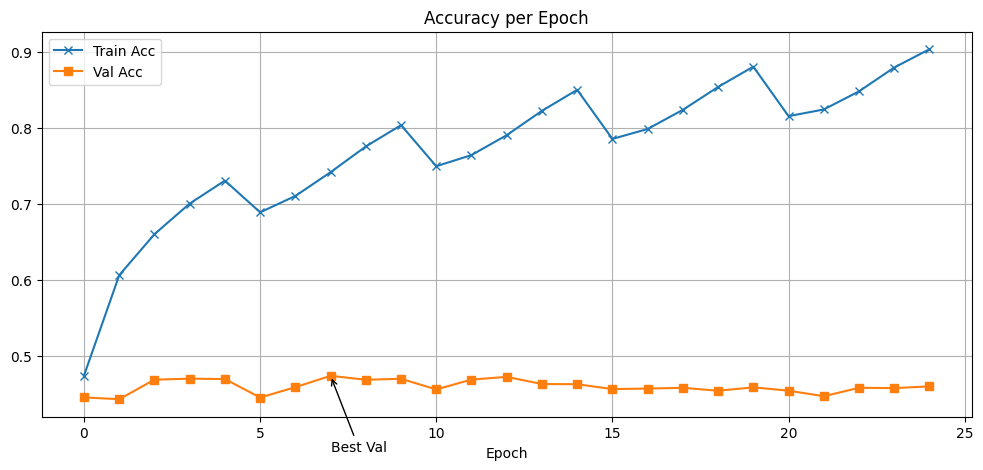

[5] Generating confusion matrix with Plotly...


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

In [13]:
import os, glob, random, numpy as np, time
import torch, torch.nn as nn
from torch.utils.data import IterableDataset, DataLoader
from torch.optim import AdamW
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pyspark.sql import SparkSession
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report

# ----------------------------------------
# 0) Initialization
# ----------------------------------------
print("[0] Starting Hybrid CNN-BiLSTM training pipeline...")
start_time = time.time()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[0] Computation device set to: {device}\n")

# ----------------------------------------
# 1) Data Loading & Normalization
# ----------------------------------------
print("[1] Loading Parquet datasets via Spark...")
class SparkSampledParquetDataset(IterableDataset):
    def __init__(self, parquet_glob, exclude_filename, window_size=100, num_features=6,
                 sample_frac=1.0, shuffle_each_epoch=True):
        print(f"    - Reading files: {parquet_glob}, excluding: {exclude_filename}")
        inc = [p for p in glob.glob(parquet_glob)
               if exclude_filename not in os.path.basename(p)]
        if not inc:
            raise FileNotFoundError("No parquet files found.")
        spark = (SparkSession.builder.appName("WISDM-Classifier")
                 .master("local[*]").getOrCreate())
        df = spark.read.parquet(*inc)
        df = df.cache() if sample_frac >= 1 else df.sample(False, float(sample_frac), 42).cache()

        self.class_names = sorted(r.label for r in df.select("label").distinct().collect())
        self.name2idx = {n:i for i,n in enumerate(self.class_names)}
        self.rows = [(np.asarray(r.features, np.float32), r.label)
                     for r in df.toLocalIterator()
                     if not (np.isnan(r.features).any() or np.isinf(r.features).any())]
        self.n = len(self.rows)
        print(f"    - Loaded {self.n:,} windows across {len(self.class_names)} classes\n")
        self.window_size, self.num_features, self.shuffle = window_size, num_features, shuffle_each_epoch

    def __len__(self): return self.n
    def __iter__(self):
        rows = self.rows.copy()
        if self.shuffle: random.shuffle(rows)
        for flat, lbl in rows:
            seq = torch.from_numpy(flat.reshape(self.window_size, self.num_features))
            m, s = seq.mean(0,True), seq.std(0,True) + 1e-5
            yield (seq - m) / s, torch.tensor(self.name2idx[lbl])

print("[1] Preparing train and validation datasets...")
train_ds = SparkSampledParquetDataset(parquet_glob="preproc/train_data_*.parquet",
                                      exclude_filename="train_data_025.parquet")
val_ds   = SparkSampledParquetDataset(parquet_glob="preproc/train_data_025.parquet",
                                      exclude_filename="§", shuffle_each_epoch=False)
train_loader = DataLoader(train_ds, batch_size=64, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=256)
print(f"[1] Dataloaders ready | Train batch size: 64 | Val batch size: 256\n")

# ----------------------------------------
# 2) Model Definition
# ----------------------------------------
print("[2] Defining CNN-BiLSTM with Attention model...")
class CNNBiLSTMClassifier(nn.Module):
    def __init__(self, input_size=6, cnn_ch=64, lstm_h=128, lstm_layers=2, n_classes=18):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(input_size, cnn_ch, 3, padding=1),
            nn.BatchNorm1d(cnn_ch), nn.ReLU(),
            nn.Conv1d(cnn_ch, cnn_ch, 3, padding=1),
            nn.BatchNorm1d(cnn_ch), nn.ReLU()
        )
        self.lstm = nn.LSTM(cnn_ch, lstm_h, lstm_layers,
                            batch_first=True, bidirectional=True, dropout=0.2)
        self.attn = nn.Linear(lstm_h*2, 1)
        self.drop = nn.Dropout(0.5)
        self.fc   = nn.Linear(lstm_h*2, n_classes)

    def forward(self, x):                # x: (B,T,F)
        x = self.conv(x.permute(0,2,1)).permute(0,2,1)    # (B,T,C)
        out,_ = self.lstm(x)                               # (B,T,2H)
        w = torch.softmax(self.attn(out).squeeze(-1), 1)   # (B,T)
        ctx = torch.sum(out * w.unsqueeze(-1), 1)          # (B,2H)
        return self.fc(self.drop(ctx))

model = CNNBiLSTMClassifier(n_classes=len(train_ds.class_names)).to(device)
print(f"[2] Model architecture:\n{model}")
print(f"[2] Total trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}\n")

# ----------------------------------------
# 3) Training Setup
# ----------------------------------------
print("[3] Setting up training components...")
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5)
epochs = 25
print(f"[3] Loss: CrossEntropy | Optimizer: AdamW | Scheduler: CosineAnnealingWarmRestarts | Epochs: {epochs}\n")

# ----------------------------------------
# 4) Training Loop
# ----------------------------------------
hist = {"tr_loss":[], "tr_acc":[], "val_acc":[]}
print("[4] Beginning training...")
best_val = 0
for epoch in range(1, epochs+1):
    print(f"[4] Epoch {epoch}/{epochs}...")
    t0 = time.time()
    model.train()
    tr_loss=tr_correct=0
    for x,y in tqdm(train_loader, desc="    Training", leave=False):
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        tr_loss += loss.item()*x.size(0)
        tr_correct += (logits.argmax(1)==y).sum().item()
    scheduler.step()
    tr_loss /= len(train_ds);
    tr_acc = tr_correct/len(train_ds)

    model.eval(); val_correct=0
    with torch.no_grad():
        for x,y in val_loader:
            x,y = x.to(device), y.to(device)
            val_correct += (model(x).argmax(1)==y).sum().item()
    val_acc = val_correct/len(val_ds)
    hist["tr_loss"].append(tr_loss); hist["tr_acc"].append(tr_acc); hist["val_acc"].append(val_acc)

    if val_acc > best_val:
        best_val = val_acc
        torch.save(model.state_dict(), "best_cnn_bilstm.pt")
        print(f"    --> New best val_acc: {val_acc:.4f}, model saved.")

    print(f"    Time: {time.time()-t0:.1f}s | loss={tr_loss:.4f} | train_acc={tr_acc:.4f} | val_acc={val_acc:.4f}\n")

print(f"[4] Training complete in {time.time()-start_time:.1f}s. Best val_acc: {best_val:.4f}\n")

# ----------------------------------------
# 5) Visualizations
# ----------------------------------------
print("[5] Plotting metrics...")
plt.figure(figsize=(12,5))
plt.plot(hist["tr_loss"], marker='o', label="Train Loss")
plt.title("Training Loss per Epoch"); plt.xlabel("Epoch"); plt.grid(True)
best_epoch = np.argmin(hist["tr_loss"]); plt.annotate('Min Loss', xy=(best_epoch, hist["tr_loss"][best_epoch]),
             xytext=(best_epoch, hist["tr_loss"][best_epoch]+0.1), arrowprops=dict(arrowstyle="->"))
plt.show()

plt.figure(figsize=(12,5))
plt.plot(hist["tr_acc"], marker='x', label="Train Acc")
plt.plot(hist["val_acc"], marker='s', label="Val Acc")
plt.title("Accuracy per Epoch"); plt.xlabel("Epoch"); plt.legend(); plt.grid(True)
best_epoch = np.argmax(hist["val_acc"])
plt.annotate('Best Val', xy=(best_epoch, hist["val_acc"][best_epoch]),
             xytext=(best_epoch, hist["val_acc"][best_epoch]-0.1), arrowprops=dict(arrowstyle="->"))
plt.show()




In [19]:


# ----------------------------------------
# 5) Save Final Model
# ----------------------------------------
print("[6] Saving final model and metadata...")
torch.save({
    "state_dict": model.state_dict(),
    "class_names": train_ds.class_names
}, "cnn_bilstm_classifier_final.pt")
print("[6] Done. Model saved ➜ cnn_bilstm_classifier_final.pt")


[6] Saving final model and metadata...
[6] Done. Model saved ➜ cnn_bilstm_classifier_final.pt


─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

[07:29:19] Sampled 889 sequences from parquet                                    <ipython-input-21-9a92fb11f531>:22

<ipython-input-21-9a92fb11f531>:25: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

Spark ➜ driver: 889seq [00:01, 879.67seq/s] 
Evaluating: 100%|██████████| 4/4 [00:00<00:00,

[07:29:20] Classification Report:                                                <ipython-input-21-9a92fb11f531>:66

              precision    recall  f1-score   support

           A       0.85      0.96      0.90        53
           B       0.95      0.76      0.85        68
           C       0.61      0.81      0.70        48
           D       0.05      0.03      0.04        30
           E       0.35      0.28      0.31        39
           F       0.28      0.41      0.33        37
           G       0.58      0.58      0.58        45
           H       0.22      0.23      0.22        22
           I       0.31      0.19      0.24        42
           J       0.19      0.50      0.27        36
           K       0.35      0.17      0.23        53
           L       0.09      0.09      0.09        44
           M       0.62      0.69      0.65        72
           O       0.38      0.58      0.46        19
           P       0.58      0.67      0.63        46
           Q       0.73      0.30      0.42        64
           R       0.70      0.37      0.48        43
           S       0.47    

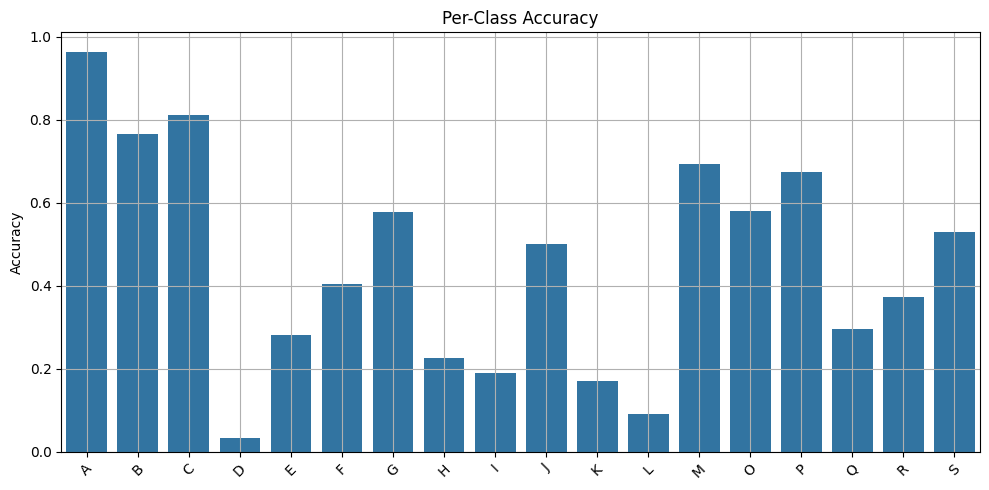

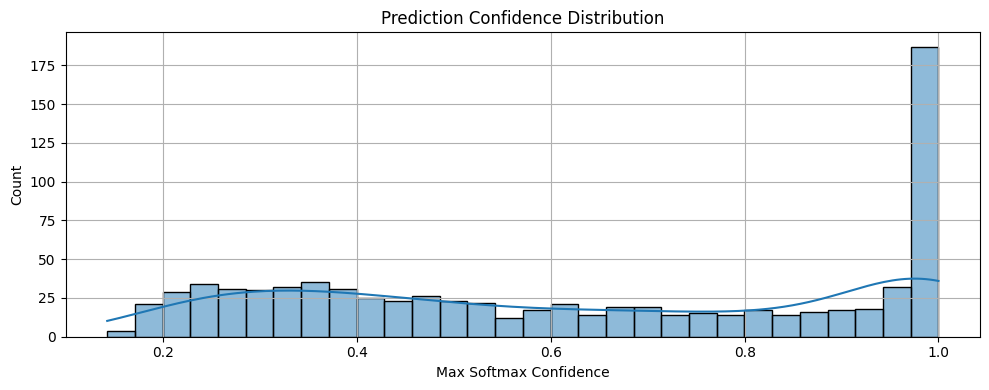

[07:29:22] 95th percentile of cross-entropy loss: 5.8178                        <ipython-input-21-9a92fb11f531>:104

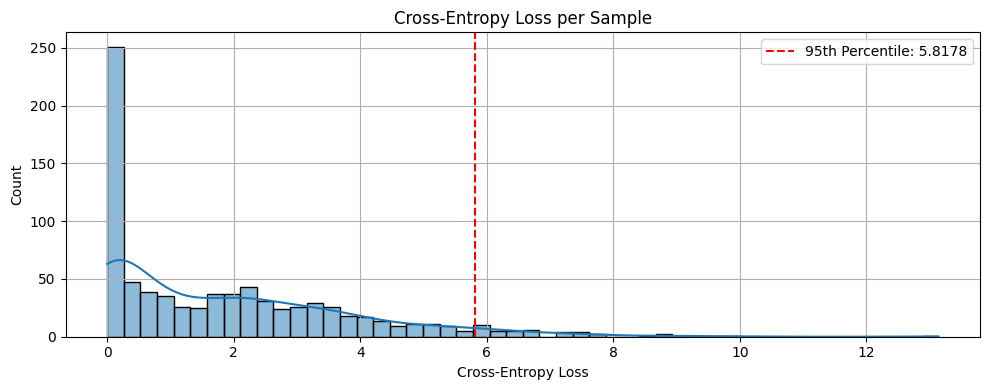

           Saved validation stats and threshold to val_classification_stats.npz <ipython-input-21-9a92fb11f531>:123

In [21]:
# Enhanced Validation: Classification + 95th percentile stats
import os, numpy as np, torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from pyspark.sql import SparkSession
from rich.console import Console
from sklearn.metrics import classification_report, confusion_matrix
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F

console = Console()
console.rule("[bold green]Validation[/bold green]")

VAL_PATH = "preproc/train_data_025.parquet"
if not os.path.exists(VAL_PATH):
    raise FileNotFoundError(f"Parquet file not found: {VAL_PATH}")

spark = SparkSession.builder.getOrCreate()
val_df = spark.read.parquet(VAL_PATH).sample(False, 0.10, seed=99).cache()
console.log(f"Sampled {val_df.count():,} sequences from parquet")

# Load model + metadata
checkpoint = torch.load("/content/cnn_bilstm_classifier_final.pt", map_location='cpu')
state_dict = checkpoint["state_dict"]
class_names = checkpoint.get("class_names")
name2idx = {n: i for i, n in enumerate(class_names)}

# Init model
model = CNNBiLSTMClassifier(n_classes=len(class_names))
model.load_state_dict(state_dict)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device).eval()

# Prepare validation tensors
x_data, y_data = [], []
for row in tqdm(val_df.toLocalIterator(), desc="Spark ➜ driver", unit="seq"):
    arr = np.asarray(row.features, dtype=np.float32)
    if np.isnan(arr).any() or np.isinf(arr).any(): continue
    seq = arr.reshape(100, 6)
    m, s = seq.mean(0, keepdims=True), seq.std(0, keepdims=True) + 1e-5
    x_data.append((seq - m) / s)
    y_data.append(name2idx[row.label])

x_tensor = torch.tensor(np.stack(x_data), dtype=torch.float32)
y_tensor = torch.tensor(y_data, dtype=torch.long)
val_loader = DataLoader(TensorDataset(x_tensor, y_tensor), batch_size=256)

# Inference loop
y_true, y_pred, y_conf, xentropy = [], [], [], []
with torch.no_grad():
    for xb, yb in tqdm(val_loader, desc="Evaluating", unit="batch"):
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        probs = F.softmax(logits, dim=1)
        preds = probs.argmax(1)
        loss_per_sample = F.cross_entropy(logits, yb, reduction='none')  # vector of losses

        y_true.extend(yb.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_conf.extend(probs.max(1)[0].cpu().numpy())  # max confidence
        xentropy.extend(loss_per_sample.cpu().numpy())

# ========================== REPORTS ===============================
console.log("[bold cyan]Classification Report:[/bold cyan]")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
fig = go.Figure(go.Heatmap(z=cm, x=class_names, y=class_names,
                           colorscale='Blues', showscale=True))
fig.update_layout(title="Validation Confusion Matrix",
                  xaxis_title="Predicted", yaxis_title="True")
fig.show()

# ========================== PER-CLASS ACCURACY ====================
correct = np.array(y_true) == np.array(y_pred)
acc_by_class = {}
for i, cname in enumerate(class_names):
    mask = np.array(y_true) == i
    acc_by_class[cname] = correct[mask].mean() if mask.any() else 0.0

plt.figure(figsize=(10, 5))
sns.barplot(x=list(acc_by_class.keys()), y=list(acc_by_class.values()))
plt.xticks(rotation=45)
plt.title("Per-Class Accuracy")
plt.ylabel("Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()

# ========================== CONFIDENCE DISTRIBUTION ===============
plt.figure(figsize=(10, 4))
sns.histplot(y_conf, kde=True, bins=30)
plt.title("Prediction Confidence Distribution")
plt.xlabel("Max Softmax Confidence")
plt.grid(True)
plt.tight_layout()
plt.show()

# ========================== 95th Percentile CrossEntropy ==========
threshold_95 = np.percentile(xentropy, 95)
console.log(f"[bold green]95th percentile of cross-entropy loss:[/bold green] {threshold_95:.4f}")

plt.figure(figsize=(10, 4))
sns.histplot(xentropy, bins=50, kde=True)
plt.axvline(threshold_95, color='red', linestyle='--', label=f'95th Percentile: {threshold_95:.4f}')
plt.title("Cross-Entropy Loss per Sample")
plt.xlabel("Cross-Entropy Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optionally save for downstream threshold-based alerting
np.savez("val_classification_stats.npz",
         y_true=np.array(y_true),
         y_pred=np.array(y_pred),
         xentropy=np.array(xentropy),
         threshold_95=threshold_95)

console.log("[green]Saved validation stats and threshold to val_classification_stats.npz[/green]")


In [22]:
# Save full model checkpoint with metadata (classification version)
checkpoint = {
    'model_class': 'CNNBiLSTMClassifier',
    'model_args': {
        'input_size': 6,
        'cnn_ch': 64,
        'lstm_h': 128,
        'lstm_layers': 2,
        'n_classes': len(train_ds.class_names)
    },
    'state_dict': model.state_dict(),
    'optimizer': optimizer.state_dict(),
    'epoch': epoch,
    'train_history': hist,
    'class_names': train_ds.class_names
}

torch.save(checkpoint, "cnn_bilstm_full_checkpoint.pth")
print("Full model checkpoint saved ➜ cnn_bilstm_full_checkpoint.pth")


Full model checkpoint saved ➜ cnn_bilstm_full_checkpoint.pth


Validation Classification Metrics Summary
              precision    recall  f1-score   support

           0      0.850     0.962     0.903        53
           1      0.945     0.765     0.846        68
           2      0.609     0.812     0.696        48
           3      0.053     0.033     0.041        30
           4      0.355     0.282     0.314        39
           5      0.278     0.405     0.330        37
           6      0.578     0.578     0.578        45
           7      0.217     0.227     0.222        22
           8      0.308     0.190     0.235        42
           9      0.189     0.500     0.275        36
          10      0.346     0.170     0.228        53
          11      0.089     0.091     0.090        44
          12      0.617     0.694     0.654        72
          13      0.379     0.579     0.458        19
          14      0.585     0.674     0.626        46
          15      0.731     0.297     0.422        64
          16      0.696     0.372     0

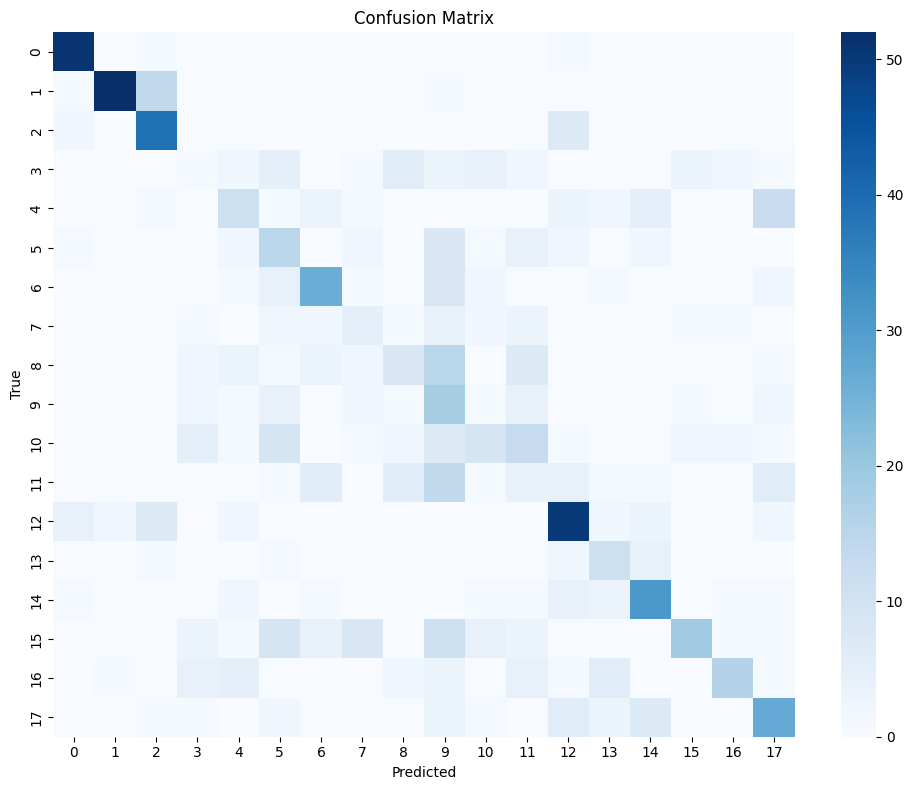

In [23]:
# Evaluation metrics from saved classification stats
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load saved metrics
data = np.load("val_classification_stats.npz")
y_true = data["y_true"]
y_pred = data["y_pred"]
xentropy = data["xentropy"]
threshold = float(data["threshold_95"])

# Classification metrics
print("="*40)
print("Validation Classification Metrics Summary")
report = classification_report(y_true, y_pred, digits=3)
print(report)
print(f"Cross-Entropy 95th percentile threshold: {threshold:.4f}")
print("="*40)

# Optional: Visual confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
